In [ ]:
pip install yfinance

In [ ]:
pip install statsmodels

In [27]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from statsmodels.tsa.holtwinters import (ExponentialSmoothing, 
                                         SimpleExpSmoothing, 
                                         Holt)
from sklearn.metrics import mean_squared_error 

In [7]:
plt.set_cmap('cubehelix')
sns.set_palette('cubehelix')

COLORS = [plt.cm.cubehelix(x) for x in [0.1, 0.3, 0.5, 0.7]]


<Figure size 432x288 with 0 Axes>

In [6]:
# 구글 주가 20100101~20181231을 가져온다. 

df = yf.download('GOOG',
                 start='2010-01-01',
                 end='2018-12-31',
                 adjusted=True,       #OHLC : Open, High, Low, Close
                 progress=False)      #progress는 기본값이 True로 되어 있는데, 


In [8]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,312.304413,313.579620,310.954468,312.204773,312.204773,3927065
2010-01-05,312.418976,312.747742,309.609497,310.829926,310.829926,6031925
2010-01-06,311.761444,311.761444,302.047852,302.994293,302.994293,7987226
2010-01-07,303.562164,303.861053,295.218445,295.940735,295.940735,12876685
2010-01-08,294.894653,300.498657,293.455048,299.885956,299.885956,9484016
...,...,...,...,...,...,...
2018-12-21,1015.299988,1024.020020,973.690002,979.539978,979.539978,4596000
2018-12-24,973.900024,1003.539978,970.109985,976.219971,976.219971,1590300
2018-12-26,989.010010,1040.000000,983.000000,1039.459961,1039.459961,2373300


In [9]:
goog = df.resample('M').last().rename(columns={'Adj Close': 'adj_close'}).adj_close

#구글의 자료 중 종가를 기준으로 월 단위 마지막 영업일을 나열한 것.

In [10]:
goog

Date
2010-01-31     263.980530
2010-02-28     262.416412
2010-03-31     282.501129
2010-04-30     261.868439
2010-05-31     241.908264
                 ...     
2018-08-31    1218.189941
2018-09-30    1193.469971
2018-10-31    1076.770020
2018-11-30    1094.430054
2018-12-31    1037.079956
Freq: M, Name: adj_close, Length: 108, dtype: float64

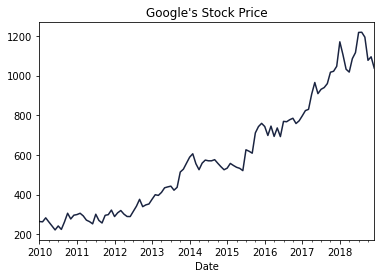

In [11]:
goog.plot(title="Google's Stock Price") 

In [12]:
train_indices = goog.index.year < 2018
goog_train = goog[train_indices]
goog_test = goog[~train_indices]

test_length = len(goog_test)

In [13]:
goog_train

Date
2010-01-31     263.980530
2010-02-28     262.416412
2010-03-31     282.501129
2010-04-30     261.868439
2010-05-31     241.908264
                 ...     
2017-08-31     939.330017
2017-09-30     959.109985
2017-10-31    1016.640015
2017-11-30    1021.409973
2017-12-31    1046.400024
Freq: M, Name: adj_close, Length: 96, dtype: float64

In [14]:
goog_test

Date
2018-01-31    1169.939941
2018-02-28    1104.729980
2018-03-31    1031.790039
2018-04-30    1017.330017
2018-05-31    1084.989990
2018-06-30    1115.650024
2018-07-31    1217.260010
2018-08-31    1218.189941
2018-09-30    1193.469971
2018-10-31    1076.770020
2018-11-30    1094.430054
2018-12-31    1037.079956
Freq: M, Name: adj_close, dtype: float64

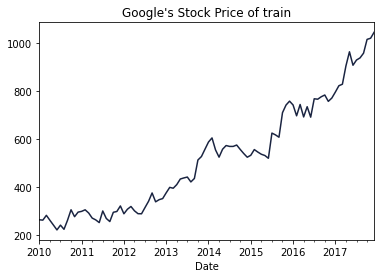

In [15]:
goog_train.plot(title="Google's Stock Price of train")

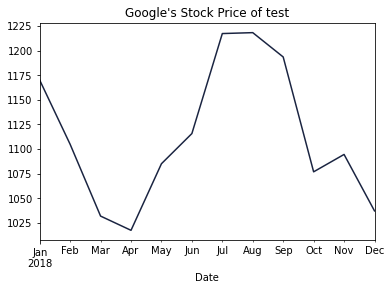

In [16]:
goog_test.plot(title="Google's Stock Price of test")

평활화 
1. 모델링을 통해 예측된 가격을 smooth하게 평활화 하는 것임.
2. 선형이라는 것은 점과 점 사이를 직선으로 연결하는 방식임.
3. 지수 로그를 방식으로 사용하면 곡선의 형태로 연결되는 방식임.
4. 마지막은 damping의 유무라고 보면될 것,

In [17]:
ses_1 = SimpleExpSmoothing(goog_train).fit(smoothing_level=0.2)
ses_forecast_1 = ses_1.forecast(test_length)

ses_2 = SimpleExpSmoothing(goog_train).fit(smoothing_level=0.5)
ses_forecast_2 = ses_2.forecast(test_length)

ses_3 = SimpleExpSmoothing(goog_train).fit()
ses_forecast_3 = ses_3.forecast(test_length)

alpha = ses_3.model.params['smoothing_level']
alpha
#3번째 smoothing_level이 없는 이유
#automatically optimized by statsmodel which is the recommended one. (자동적으로 조정하는 것)
#따라서 알파는 0.9410의 값으로 조정된 값을 볼 수 있음.

0.9410089011176584

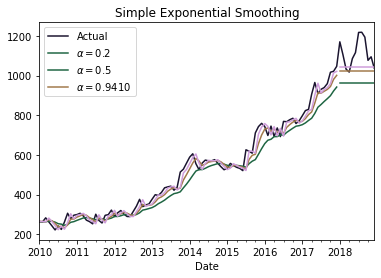

In [18]:
goog.plot(color=COLORS[0], 
          title='Simple Exponential Smoothing', label='Actual', legend=True)
# 원 데이터 (2010~2019의 데이터로 goog.plot(title="Google's Stock Price")에 해당함. )
ses_forecast_1.plot(color=COLORS[1], legend=True, label=r'$\alpha=0.2$')
ses_1.fittedvalues.plot(color=COLORS[1])

ses_forecast_2.plot(color=COLORS[2], legend=True, label=r'$\alpha=0.5$')
ses_2.fittedvalues.plot(color=COLORS[2])

ses_forecast_3.plot(color=COLORS[3], legend=True, label=r'$\alpha={0:.4f}$'.format(alpha))
ses_3.fittedvalues.plot(color=COLORS[3])


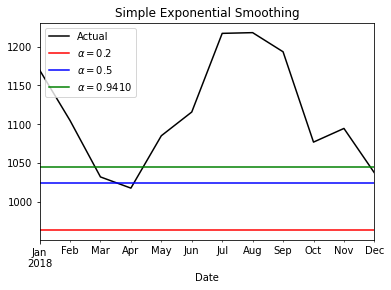

In [19]:
goog_test.plot(color='black', 
          title='Simple Exponential Smoothing', label='Actual', legend=True)
ses_forecast_1.plot(color='red', legend=True, label=r'$\alpha=0.2$')
ses_forecast_2.plot(color='blue', legend=True, label=r'$\alpha=0.5$')
ses_forecast_3.plot(color='green', legend=True, label=r'$\alpha={0:.4f}$'.format(alpha))

In [74]:
def RMSE (Forecast):
  RMSE = pd.DataFrame( {'Observed': goog_test, 'Predicted': Forecast})
  rmse = np.sqrt(mean_squared_error(RMSE.Observed, RMSE.Predicted))
  print("\nAccuracy measures ")
  print('RMSE: %.3f' %rmse)

#이것은 RMSE로 Root Mean Squared Error임. 관측치와 예측치의 값을 오차항이라고 하는데,
#여기서 오차항을 제곱하고 루트를 하여 절대값으로 표시한 error로 보면 됨. (낮으면 좋음)

In [75]:
print(RMSE(ses_forecast_1))
print(RMSE(ses_forecast_2))
print(RMSE(ses_forecast_3)) #3번째 항목의 RMSE가 가장 낮음.


Accuracy measures 
RMSE: 165.339
None

Accuracy measures 
RMSE: 112.685
None

Accuracy measures 
RMSE: 96.654
None


In [56]:
ses_3.summary()

Dep. Variable:,endog,No. Observations:,96
Model:,SimpleExpSmoothing,SSE,95987.178
Optimized:,True,AIC,667.132
Trend:,None,BIC,672.260
Seasonal:,None,AICC,667.571
Seasonal Periods:,None,Date:,"Mon, 30 Aug 2021"
Box-Cox:,False,Time:,14:56:16
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9410089,alpha,True
initial_level,263.98014,l.0,True


In [22]:
# Holt's model with linear trend (트렌드가 선형이다)
hs_1 = Holt(goog_train).fit()
hs_forecast_1 = hs_1.forecast(test_length)

# Holt's model with exponential trend (트랜드가 지수함수 형식이다)
hs_2 = Holt(goog_train, exponential=True).fit()
hs_forecast_2 = hs_2.forecast(test_length)

# Holt's model with exponential trend and damping (트랜드가 지수함수 형식이지만 지수는 1보다 작다)
hs_3 = Holt(goog_train, exponential=True, damped=True).fit(damping_slope=0.99)
hs_forecast_3 = hs_3.forecast(test_length)

# Holt's model with exponential trend and damping (optimze 방식 사용)
hs_4 = Holt(goog_train, exponential=True, damped=True).fit()
hs_forecast_4 = hs_4.forecast(test_length)
#An exponential model would be appropriate for situations where the increase or decrease starts slowly but then accelerates rapidly.
#exponential은 slope가 점차 증가하는 데이터에 적합함. (지수함수처럼 시작부분은 조금 증가하지만 점차 큰 값으로 증가함)

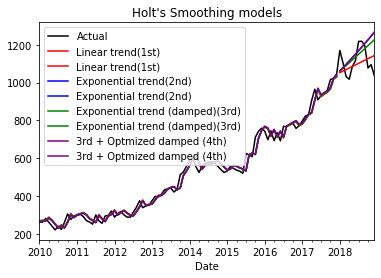

In [57]:
goog.plot(color='black', title="Holt's Smoothing models", label='Actual', legend=True)

hs_1.fittedvalues.plot(color='red', legend=True, label='Linear trend(1st)')         #train 부분
hs_forecast_1.plot(color='red', legend=True, label='Linear trend(1st)')             #test 부분

hs_2.fittedvalues.plot(color='blue', legend=True, label='Exponential trend(2nd)')   #train 부분
hs_forecast_2.plot(color='blue', legend=True, label='Exponential trend(2nd)')       #test 부분

hs_3.fittedvalues.plot(color='green', legend=True, label='Exponential trend (damped)(3rd)') #train 부분
hs_forecast_3.plot(color='green', legend=True, label='Exponential trend (damped)(3rd)')     #test 부분

hs_4.fittedvalues.plot(color='purple', legend=True, label='3rd + Optmized damped (4th)') #train 부분
hs_forecast_4.plot(color='purple', legend=True, label='3rd + Optmized damped (4th)')     #test 부분

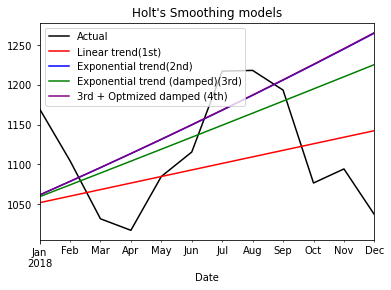

In [58]:
goog_test.plot(color='black', title="Holt's Smoothing models", label='Actual', legend=True)
hs_forecast_1.plot(color='red', legend=True, label='Linear trend(1st)')        
hs_forecast_2.plot(color='blue', legend=True, label='Exponential trend(2nd)')  
hs_forecast_3.plot(color='green', legend=True, label='Exponential trend (damped)(3rd)')
hs_forecast_4.plot(color='purple', legend=True, label='3rd + Optmized damped (4th)')
#결과를 보면, SES(위의 단순지수평활화, red line 1st)보다 더 적합한 예측을 보여줌. trend를 예측에 반영하기 때문임.
#두번째는 지수함수의 형태로 트랜드를 반영하였던 것으로 damped는 반영하지 않아서 좀 더 가파른 형태가 나옴.
#마지막은 damped를 반영하여 지수값이 1보다 작기에 트렌드가 지수형태지만 증가폭은 감소하고 있다고 해석하면 됨.
#참고로 4번째와 2번째 함수가 거의 일치하는데, 4th의 damping_slope=1로 설정되었기 떄문임.
#하지만, 그래프만 보면, 어떤 것이 더 정확한지 판단하기 어렵다. 따라서 RMSE를 통해서 정확도를 검증한다.


In [77]:
print(RMSE(hs_forecast_1)) #트렌드를 선형으로 반영한 HS모델의 정확도가 가장 높았음. (조금 의외)
print(RMSE(hs_forecast_2))
print(RMSE(hs_forecast_3))
print(RMSE(hs_forecast_4))


Accuracy measures 
RMSE: 74.905
None

Accuracy measures 
RMSE: 103.846
None

Accuracy measures 
RMSE: 89.452
None

Accuracy measures 
RMSE: 104.083
None


In [60]:
SEASONAL_PERIODS = 12
# 기간을 분기별, 월별, 주별로 표시할 수 있음. (4,12,52로) 하지만, 우리는 이미 구글 주가를 월별로 가져왔었음.

# Holt-Winter's model with exponential trend. 
#trend는 mul(multi), add(additive)로 나뉨. 만약 트랜드가 add라면 trend=add로 작성하면 됨.
hw_1 = ExponentialSmoothing(goog_train, trend='mul', seasonal='add', 
                            seasonal_periods=SEASONAL_PERIODS).fit()
hw_forecast_1 = hw_1.forecast(test_length)

# Holt-Winter's model with exponential trend and damping
hw_2 = ExponentialSmoothing(goog_train, trend='mul', seasonal='add', 
                            seasonal_periods=SEASONAL_PERIODS, damped=True).fit()
hw_forecast_2 = hw_2.forecast(test_length)


# Holt-Winter's model with additive trend and damping
hw_3 = ExponentialSmoothing(goog_train, trend='add', seasonal='add', 
                            seasonal_periods=SEASONAL_PERIODS, damped=True).fit()
hw_forecast_3 = hw_3.forecast(test_length)


# Holt-Winter's model with add trend (seasonal : mul and damped ture)
hw_4 = ExponentialSmoothing(goog_train, trend='add', seasonal='mul', 
                            seasonal_periods=SEASONAL_PERIODS, damped=True).fit()
hw_forecast_4 = hw_4.forecast(test_length)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [139]:
hw_2.params

{'damping_slope': 0.9970433827752997,
 'initial_level': 486.10838446167,
 'initial_seasons': array([-221.65753298, -223.19763416, -204.38410896, -224.69913272,
        -243.95524238, -264.52650941, -244.09400713, -261.16579096,
        -224.67109013, -181.41773617, -209.24583419, -191.03453411]),
 'initial_slope': 1.0072688163737915,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.8947368397757072,
 'smoothing_seasonal': 0.10526315556518095,
 'smoothing_slope': 0.052475967514488055,
 'use_boxcox': False}

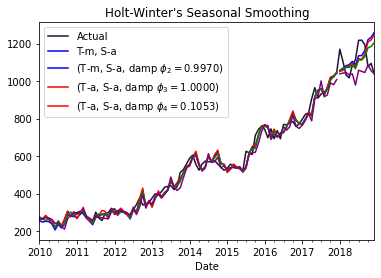

In [63]:
goog.plot(color=COLORS[0], title="Holt-Winter's Seasonal Smoothing",label='Actual',
          legend=True)

hw_1.fittedvalues.plot(color='blue')
hw_forecast_1.plot(color='blue', legend=True, label='T-m, S-a')

phi_2 = hw_2.model.params['damping_slope']
plot_label_2 = f'(T-m, S-a, damp $\phi_2={phi_2:.4f}$)'

hw_2.fittedvalues.plot(color='red')
hw_forecast_2.plot(color='red', legend=True, label=plot_label_2)

phi_3 = hw_3.model.params['damping_slope']
plot_label_3 = f'(T-a, S-a, damp $\phi_3={phi_3:.4f}$)'

hw_3.fittedvalues.plot(color='green')
hw_forecast_3.plot(color='green', legend=True, label=plot_label_3)

phi_4 = hw_4.model.params['damping_slope']
plot_label_4 = f'(T-a, S-a, damp $\phi_4={phi_4:.4f}$)'

hw_4.fittedvalues.plot(color='purple')
hw_forecast_4.plot(color='purple', legend=True, label=plot_label_4)


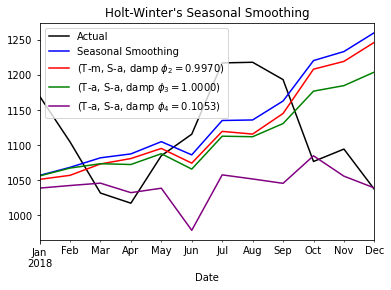

In [65]:
goog_test.plot(color='black', title="Holt-Winter's Seasonal Smoothing",label='Actual',
          legend=True)

hw_forecast_1.plot(color='blue', legend=True, label='Seasonal Smoothing')

phi_2 = hw_2.model.params['damping_slope']
plot_label_2 = f'(T-m, S-a, damp $\phi_2={phi_2:.4f}$)'
hw_forecast_2.plot(color='red', legend=True, label=plot_label_2)

phi_3 = hw_3.model.params['damping_slope']
plot_label_3 = f'(T-a, S-a, damp $\phi_3={phi_3:.4f}$)'
hw_forecast_3.plot(color='green', legend=True, label=plot_label_3)

phi_4 = hw_4.model.params['damping_slope']
plot_label_4 = f'(T-a, S-a, damp $\phi_4={phi_4:.4f}$)'
hw_forecast_4.plot(color='purple', legend=True, label=plot_label_4)

In [81]:
print(RMSE(hw_forecast_1))
print(RMSE(hw_forecast_2))
print(RMSE(hw_forecast_3))
print(RMSE(hw_forecast_4))


Accuracy measures 
RMSE: 102.930
None

Accuracy measures 
RMSE: 101.289
None

Accuracy measures 
RMSE: 88.450
None

Accuracy measures 
RMSE: 99.565
None


#최종적으로 가장 낮은 RMSE를 보여준 모형은 hs_forecast_1으로 나온다.

hs_forecast_1은 트랜드가 linear 하다고 가정하고 예측한 모형임